# Assignment 3 - SMAI - Mutli Layer Perceptron

In [1]:
import os
import sys

# enter the Foldername here:
FOLDERNAME = "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man"

if FOLDERNAME is None or not os.path.exists(FOLDERNAME):
    FOLDERNAME = os.getcwd()

PATHNAME = f"{FOLDERNAME}"
sys.path.append(f"{FOLDERNAME}")

# DATA_FOLDER = os.path.join(FOLDERNAME, "SMAI-Dataset-release/IIIT-CFW")
DATA_FOLDER = os.path.join(FOLDERNAME, "datasets")
YAML_FOLDER = os.path.join(FOLDERNAME, "yaml-files")
print(DATA_FOLDER)
print(YAML_FOLDER)

/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/datasets
/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/yaml-files


In [2]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import copy
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import wandb

In [4]:
from src import *
from src.classifiers import *

In [5]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vanshg. Use `wandb login --relogin` to force relogin


True

## Problem 2 - Multi Layer Perceptron Classification

## (2.0) - Data Loading and Preprocessing

In [6]:
wine_df = pd.read_csv(os.path.join(DATA_FOLDER, "wineqt.csv"))

# printing the mean, standard deviation, min and max for each column
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [7]:
def load_wine_dataset(path):
    wine_df = pd.read_csv(path)
    X, y = wine_df.iloc[:, :-2].to_numpy(), wine_df.iloc[:, -2].to_numpy()
    y -= np.min(y) # making the range of classes to be between [0, 5]
    return X, y

X, y = load_wine_dataset(os.path.join(DATA_FOLDER, "wineqt.csv"))

print(f"Shape of wine data: {X.shape}")
print(f"Shape of wine target classes: {y.shape}")

Shape of wine data: (1143, 11)
Shape of wine target classes: (1143,)


#### Train, Val, Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.33, random_state=42
)

print(f"Size of training set: {X_train.shape}")
print(f"Size of validation set: {X_val.shape}")
print(f"Size of testing set: {X_test.shape}")

Size of training set: (800, 11)
Size of validation set: (114, 11)
Size of testing set: (229, 11)


#### Standarizing the data

In [9]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

print(f"Mean of training features:\n{scaler.mean_}\n")
print(f"Variance of training features: {scaler.var_}")

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Mean of training features:
[ 8.24225     0.52955625  0.2644375   2.5051875   0.08655875 15.703125
 45.54125     0.99668604  3.314925    0.6580125  10.437125  ]

Variance of training features: [2.84383994e+00 3.15808968e-02 3.70914336e-02 1.67394496e+00
 2.14769905e-03 1.04172178e+02 9.53580798e+02 3.55576542e-06
 2.28689944e-02 2.82864248e-02 1.13723701e+00]


### Dimensionality Reduction

In [10]:
wine_pca = PCA(n_components=2)
wine_pca.fit(X_train)

X_train_reduced = wine_pca.transform(X_train)
X_val_reduced = wine_pca.transform(X_val)
X_test_reduced = wine_pca.transform(X_test)

print(f"Shape of reduced training set: {X_train_reduced.shape}")
print(f"Shape of reduced validation set: {X_val_reduced.shape}")
print(f"Shape of reduced testing set: {X_test_reduced.shape}")

Shape of reduced training set: (800, 2)
Shape of reduced validation set: (114, 2)
Shape of reduced testing set: (229, 2)


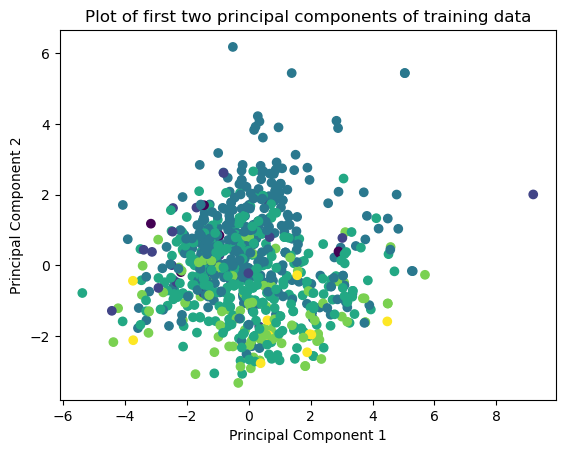

In [11]:
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train)
plt.title("Plot of first two principal components of training data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [17]:
wine_data_path = os.path.join(DATA_FOLDER, "wineqt.csv")
X_train, X_val, X_test, y_train, y_val, y_test = get_and_process_wine_dataset(wine_data_path)

print(f"Size of training set: {X_train.shape}, {y_train.shape}")
print(f"Size of validation set: {X_val.shape}, {y_val.shape}")
print(f"Size of testing set: {X_test.shape}, {y_test.shape}")

Size of training set: (800, 11), (800,)
Size of validation set: (114, 11), (114,)
Size of testing set: (229, 11), (229,)


### Single Wandb config

In [19]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "adam",
        "model": {
            "input_dim" : 11,
            "activation": "relu",
            "hidden_dims1": 8,
            "num_classes": 6,
        },
        "optimizer": {
            "update_rule" : "sgd",
            "learning_rate": 1e-2,
        },
        "training": {
            "update_type": "minibatch",
            "batch_size": 32,
            "epochs": 100,
            "print_every": 100,
            # "log_wandb": True,
            "verbose": True
        }
    }
}

best_model = trigger_training(config["parameters"], X_train, y_train, X_val, y_val)

[11, 8]
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 1 | Train Accuracy: 39.875 | Val Accuracy: 43.860 | Train loss: 5.2518 | Val loss: 5.7145

Epoch: 2 | Train Accuracy: 45.125 | Val Accuracy: 43.860 | Train loss: 3.2000 | Val loss: 3.8410

Epoch: 3 | Train Accuracy: 48.500 | Val Accuracy: 45.614 | Train loss: 2.5845 | Val loss: 3.1433

Iteration: 100/2500 | loss = 3.6418
Epoch: 4 | Train Accuracy: 49.750 | Val Accuracy: 46.491 | Train loss: 2.2870 | Val loss: 2.6847

Epoch: 5 | Train Accuracy: 49.625 | Val Accuracy: 46.491 | Train loss: 2.0659 | Val loss: 2.3728

Epoch: 6 | Train Accuracy: 50.375 | Val Accuracy: 47.368 | Train loss: 1.9111 | Val loss: 2.1096

Epoch: 7 | Train Accuracy: 51.000 | Val Accuracy: 48.246 | Train loss: 1.7853 | Val loss: 1.9593

Iteration: 200/2500 | loss = 2.1746
Epoch: 8 | Train Accuracy: 50.750 | Val Accuracy: 51.754 | Train loss: 1.6752 | Val loss: 1.8365

Epoch: 9 | Train Accuracy: 51.250 | Val Accuracy: 46.491 | Train loss: 1.5877 | Val loss

In [16]:
wandb.init(
    project="smai-assignment3-task2",
    config=config
)

wandb.run.name = "testing"
trigger_training(config["parameters"])
wandb.finish()

Epoch: 1 | Train Accuracy: 21.250 | Val Accuracy: 19.298 | Train loss: 2.5582 | Val loss: 3.0968

Epoch: 2 | Train Accuracy: 27.875 | Val Accuracy: 25.439 | Train loss: 1.8777 | Val loss: 2.3546

Epoch: 3 | Train Accuracy: 37.375 | Val Accuracy: 33.333 | Train loss: 1.5456 | Val loss: 2.0332

Iteration: 100/2500 | loss = 1.3907
Epoch: 4 | Train Accuracy: 42.000 | Val Accuracy: 38.596 | Train loss: 1.4069 | Val loss: 1.8392

Epoch: 5 | Train Accuracy: 34.500 | Val Accuracy: 34.211 | Train loss: 1.4358 | Val loss: 1.8244

Epoch: 6 | Train Accuracy: 34.250 | Val Accuracy: 34.211 | Train loss: 1.5331 | Val loss: 1.9131

Epoch: 7 | Train Accuracy: 50.375 | Val Accuracy: 45.614 | Train loss: 1.6374 | Val loss: 2.0740

Iteration: 200/2500 | loss = 1.6440
Epoch: 8 | Train Accuracy: 50.875 | Val Accuracy: 44.737 | Train loss: 1.2495 | Val loss: 1.6202

Epoch: 9 | Train Accuracy: 48.625 | Val Accuracy: 42.105 | Train loss: 1.2401 | Val loss: 1.6219

Epoch: 10 | Train Accuracy: 46.875 | Val Accur

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▃▆▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇███████
train_loss,█▄▄▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▆▅▇▇▇▅▇▇▇▇▆█████▇██████████▆█████████
val_loss,█▄▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train_acc,0.63
train_loss,0.94063
val_acc,0.55263
val_loss,1.41898


In [29]:
np.random.seed(42)
model = FullyConnectedNet(X_train.shape[-1], [100], 6, activation='relu')
criterion = softmax_loss
optimizer = Optimizer(model, update_rule='adam', optim_config={"learning_rate": 1e-2})
train(
    model, criterion, optimizer, X_train, y_train, X_val, y_val, 
    num_epochs=1, print_every=1)

print("Hurray")

Iteration: 1/80 | loss = 27.7780
Iteration: 2/80 | loss = 29.4186
Iteration: 3/80 | loss = 26.1625
Iteration: 4/80 | loss = 17.3935
Iteration: 5/80 | loss = 17.0890
Iteration: 6/80 | loss = 18.3250
Iteration: 7/80 | loss = 13.9286
Iteration: 8/80 | loss = 10.9384
Epoch: 1 | Train Accuracy: 37.125 | Val Accuracy: 35.965 | Train loss: 10.8477 | Val loss: 9.5482

Iteration: 9/80 | loss = 9.9217
Iteration: 10/80 | loss = 12.1679
Iteration: 11/80 | loss = 10.2497
Iteration: 12/80 | loss = 8.0382
Iteration: 13/80 | loss = 6.7345
Iteration: 14/80 | loss = 7.6644
Iteration: 15/80 | loss = 8.3755
Iteration: 16/80 | loss = 8.9932
Epoch: 2 | Train Accuracy: 48.125 | Val Accuracy: 56.140 | Train loss: 7.7569 | Val loss: 6.5811

Iteration: 17/80 | loss = 7.4656
Iteration: 18/80 | loss = 8.9643
Iteration: 19/80 | loss = 8.3291
Iteration: 20/80 | loss = 6.6001
Iteration: 21/80 | loss = 5.7609
Iteration: 22/80 | loss = 5.4624
Iteration: 23/80 | loss = 5.7367
Iteration: 24/80 | loss = 6.0742
Epoch: 3 |

## Wandb Sweep

In [13]:
def make_wandb_run_name(config):
    model_config = config["model"]
    optim_config = config["optimizer"]
    train_config = config["training"]

    num_layers = model_config.get("num_layers", 1)
    
    hidden_dims = []
    for i in range(1, num_layers + 1):
        dim = model_config[f"hidden_dims{i}"]
        hidden_dims.append(str(dim))
    
    h = "-".join(hidden_dims)

    activ = model_config["activation"]
    lr = optim_config["learning_rate"]
    update_rule = optim_config["update_rule"]
    update_type = train_config["update_type"]
    batch = train_config["batch_size"]

    run_name = f"H{h}-{activ}-lr{lr}-{update_type}-{update_rule}-batch{batch}"
    return run_name

def re_nest_config(config_dict):
    nested_config = copy.deepcopy(config_dict)
    flattened_params = [key for key in config_dict.keys() if '.' in key]
    for param in flattened_params:
        value = nested_config.pop(param)
        param_levels = param.split('.')
        parent = nested_config
        for i, level in enumerate(param_levels):
            if not isinstance(parent, dict):
                break
            if i + 1 == len(param_levels):
                parent[level] = value
            
            if level not in parent.keys():
                parent[level] = {}
            
            parent = parent[level]

    return nested_config

def sweep_agent_manager():
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))
    # setting the wandb run name for the current config
    run_name = make_wandb_run_name(config)
    print(f"Run Name: {run_name}")
    run.name = run_name
    # start the training
    trigger_training(config)

In [52]:
sweep_configuration = {
    "method": "grid",
    "name": "single-layer-sgd-grid-search",
    "parameters": {
        "criterion": {"value": "softmax"},
        "model": {
            "parameters": {
                "input_dim" : {"value": 11},
                "activation": {
                    "values": ["relu", "sigmoid", "tanh"]
                },
                "hidden_dims": {
                    "values": [8, 16, 32, 64, 128]
                },
                "num_classes": {"value": 6}
            }
        },
        "optimizer": {
            "parameters": {
                "update_rule" : {"values": "sgd"},
                "learning_rate": {
                    "values": [1e-4, 5e-4, 1e-3, 1e-2, 0.1],
                },
            }
        },
        "training": {
            "parameters": {
                "update_type": {
                    "values": ["minibatch", "batch", "stochastic"]
                },
                "batch_size": {
                    "values": [16, 32, 64, 128]
                },
                "epochs": {
                    "value": 500
                },
                "log_wandb": {"values": True}
            }
        }
    }
}

In [43]:
sweep_configuration = {
    "method": "grid",
    "name": "single-layer-sgd-grid-search",
    "parameters": {
        "criterion": {"value": "softmax"},

        # model config
        "model.input_dim": {"value": 11},
        "model.activation": {
            "values": ["relu", "sigmoid", "tanh"]
        },
        "model.hidden_dims": {
            "values": [8, 16, 32, 64, 128]
        },
        "model.num_classes": {"value": 6},

        # optimizer config
        "optimizer.update_rule": {"values": ["sgd"]},
        "optimizer.learning_rate": {
            "values": [1e-4, 5e-4, 1e-3, 1e-2, 0.1],
        },

        # training config
        "training.update_type": {
            "values": ["minibatch", "batch", "stochastic"]
        },
        "training.batch_size": {
            "values": [16, 32, 64, 128]
        },
        "training.epochs": {
            "value": 500
        },
        "training.log_wandb": {"values": [True]},
        "training.verbose": {"value": False}
    }
}

In [14]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "adam",
        "model": {
            "input_dim" : 11,
            "activation": "relu",
            "hidden_dims": 128,
            "num_classes": 6
        },
        "optimizer": {
            "update_rule" : "sgd",
            "learning_rate": 1e-2,
        },
        "training": {
            "update_type": "minibatch",
            "batch_size": 32,
            "epochs": 100,
            "print_every": 100,
            "log_wandb": True,
            "verbose": True
        }
    }
}

# best_model = trigger_training(config["parameters"])

In [24]:
import yaml

f = open(os.path.join(YAML_FOLDER, "single-layer-sgd-grid-search.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration.values())

dict_values(['grid', 'single-layer-sgd-grid-search', {'criterion': {'value': 'softmax'}, 'model.input_dim': {'value': 11}, 'model.activation': {'values': ['relu', 'sigmoid', 'tanh']}, 'model.num_layers': {'value': 2}, 'model.hidden_dims1': {'values': [8, 16, 32, 64, 128]}, 'model.hidden_dims2': {'values': [16]}, 'model.num_classes': {'value': 6}, 'optimizer.update_rule': {'value': 'sgd'}, 'optimizer.learning_rate': {'values': [0.0001, 0.0005, 0.001, 0.01, 0.1]}, 'training.update_type': {'values': ['minibatch', 'batch', 'stochastic']}, 'training.batch_size': {'values': [8, 16, 64, 128]}, 'training.epochs': {'value': 500}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': False}}])


In [15]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task2")

Create sweep with ID: odn97shn
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task2/sweeps/odn97shn


In [16]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

wandb: Agent Starting Run: u2qg7opf with config:
wandb: 	criterion: softmax
wandb: 	model.activation: relu
wandb: 	model.hidden_dims1: 8
wandb: 	model.hidden_dims2: 16
wandb: 	model.input_dim: 11
wandb: 	model.num_classes: 6
wandb: 	model.num_layers: 2
wandb: 	optimizer.learning_rate: 0.0001
wandb: 	optimizer.update_rule: sgd
wandb: 	training.batch_size: 8
wandb: 	training.epochs: 500
wandb: 	training.log_wandb: True
wandb: 	training.update_type: minibatch
wandb: 	training.verbose: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'criterion': 'softmax', 'model': {'activation': 'relu', 'hidden_dims1': 8, 'hidden_dims2': 16, 'input_dim': 11, 'num_classes': 6, 'num_layers': 2}, 'optimizer': {'learning_rate': 0.0001, 'update_rule': 'sgd'}, 'training': {'batch_size': 8, 'epochs': 500, 'log_wandb': True, 'update_type': 'minibatch', 'verbose': False}}
8-16
Run Name: H8-16-relu-lr0.0001-minibatch-sgd-batch8
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5'])

BEST VAL ACCURACY : 62.2807 | epoch: 421 | Val loss: 1.2490
Best Parameters have been loaded in the model


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇██▇█▇██
train_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▅▅▆▅▅▅▅▆▅▅▅▅▅▅▅▅▄▆▆▅▅▆▇▆▇▇▇▇▇▇▇▇▆██▆▇
val_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,500
train_acc,0.5625
train_loss,1.09294
val_acc,0.57018
val_loss,1.23378


wandb: Agent Starting Run: pba0v04d with config:
wandb: 	criterion: softmax
wandb: 	model.activation: relu
wandb: 	model.hidden_dims1: 8
wandb: 	model.hidden_dims2: 16
wandb: 	model.input_dim: 11
wandb: 	model.num_classes: 6
wandb: 	model.num_layers: 2
wandb: 	optimizer.learning_rate: 0.0001
wandb: 	optimizer.update_rule: sgd
wandb: 	training.batch_size: 8
wandb: 	training.epochs: 500
wandb: 	training.log_wandb: True
wandb: 	training.update_type: batch
wandb: 	training.verbose: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'criterion': 'softmax', 'model': {'activation': 'relu', 'hidden_dims1': 8, 'hidden_dims2': 16, 'input_dim': 11, 'num_classes': 6, 'num_layers': 2}, 'optimizer': {'learning_rate': 0.0001, 'update_rule': 'sgd'}, 'training': {'batch_size': 8, 'epochs': 500, 'log_wandb': True, 'update_type': 'batch', 'verbose': False}}
8-16
Run Name: H8-16-relu-lr0.0001-batch-sgd-batch8
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5'])

BEST VAL ACCURACY : 37.7193 | epoch: 442 | Val loss: 8.7036
Best Parameters have been loaded in the model


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,█▆▅▄▃▁▂▂▁▁▁▁▂▃▃▃▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂
train_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▃▂▂▂▂▁▂▂▆▆▅▅▅▂▂▄▄▅▅▄▅▅▅▅▅▅▅▆▇▇▇▇▇▇█▇█▇▇
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,500
train_acc,0.285
train_loss,9.68455
val_acc,0.36842
val_loss,7.95756


wandb: Agent Starting Run: lp681rzv with config:
wandb: 	criterion: softmax
wandb: 	model.activation: relu
wandb: 	model.hidden_dims1: 8
wandb: 	model.hidden_dims2: 16
wandb: 	model.input_dim: 11
wandb: 	model.num_classes: 6
wandb: 	model.num_layers: 2
wandb: 	optimizer.learning_rate: 0.0001
wandb: 	optimizer.update_rule: sgd
wandb: 	training.batch_size: 8
wandb: 	training.epochs: 500
wandb: 	training.log_wandb: True
wandb: 	training.update_type: stochastic
wandb: 	training.verbose: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: ERROR Error while calling W&B API: could not find agent cfub3ff8 during agentHeartbeat (<Response [404]>)
Exception in thread Thread-6 (_heartbeat):
Traceback (most recent call last):
  File "/home/richard/anaconda3/envs/smai/lib/python3.11/site-packages/wandb/sdk/lib/retry.py", line 131, in __call__
    result = self._call_fn(*args, **kwargs)
            

{'criterion': 'softmax', 'model': {'activation': 'relu', 'hidden_dims1': 8, 'hidden_dims2': 16, 'input_dim': 11, 'num_classes': 6, 'num_layers': 2}, 'optimizer': {'learning_rate': 0.0001, 'update_rule': 'sgd'}, 'training': {'batch_size': 8, 'epochs': 500, 'log_wandb': True, 'update_type': 'stochastic', 'verbose': False}}
8-16
Run Name: H8-16-relu-lr0.0001-stochastic-sgd-batch8
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5'])


wandb: ERROR Error while calling W&B API: run smai-assignment3-task2/lp681rzv not found during createRunFiles (<Response [404]>)
wandb: ERROR Error while calling W&B API: sweep odn97shn not found (<Response [404]>)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: Ctrl + C detected. Stopping sweep.


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)



BEST VAL ACCURACY : 62.2807 | epoch: 421 | Val loss: 1.2490

wandb: ERROR Error while calling W&B API: run vanshg/smai-assignment3-task2/lp681rzv was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Problem finishing run
Exception in thread Thread-14 (_run_job):
Traceback (most recent call last):
  File "/home/richard/anaconda3/envs/smai/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/tmp/ipykernel_328769/2713679733.py", line 54, in sweep_agent_manager
  File "/tmp/ipykernel_328769/3315037542.py", line 13, in trigger_training
  File "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/src/utils.py", line 160, in train
    print(f"\nBEST VAL ACCURACY : {best_val_acc*100:.4f} | epoch: {best_epoch} | Val loss: {loss_at_best_val:.4f}")
  File "/home/richard/anaconda3/envs/smai/lib/python3.11/site-packages/wandb/sdk/lib/redirect.py", line 640, in write
    self._old_writ